In [ ]:
!unzip -q '/content/drive/MyDrive/Conglomerate Concrete Crack Detection.zip'

replace Conglomerate Concrete Crack Detection/Test/images/CFD_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
import os

def load_image_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255


    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32) / 255

    return image, mask

def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    if tf.random.uniform(()) > 0.5:
        image = tf.image_brightness(image, max_delta=0.1)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.contrast(image, lower=0.9, upper=1.1)

    return image, mask

def create_dataset(image_dir, mask_dir, batch_size=16, augment_data=False): # Added augment_data as an argument with a default value of False
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])


    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(buffer_size=1000) if augment_data else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

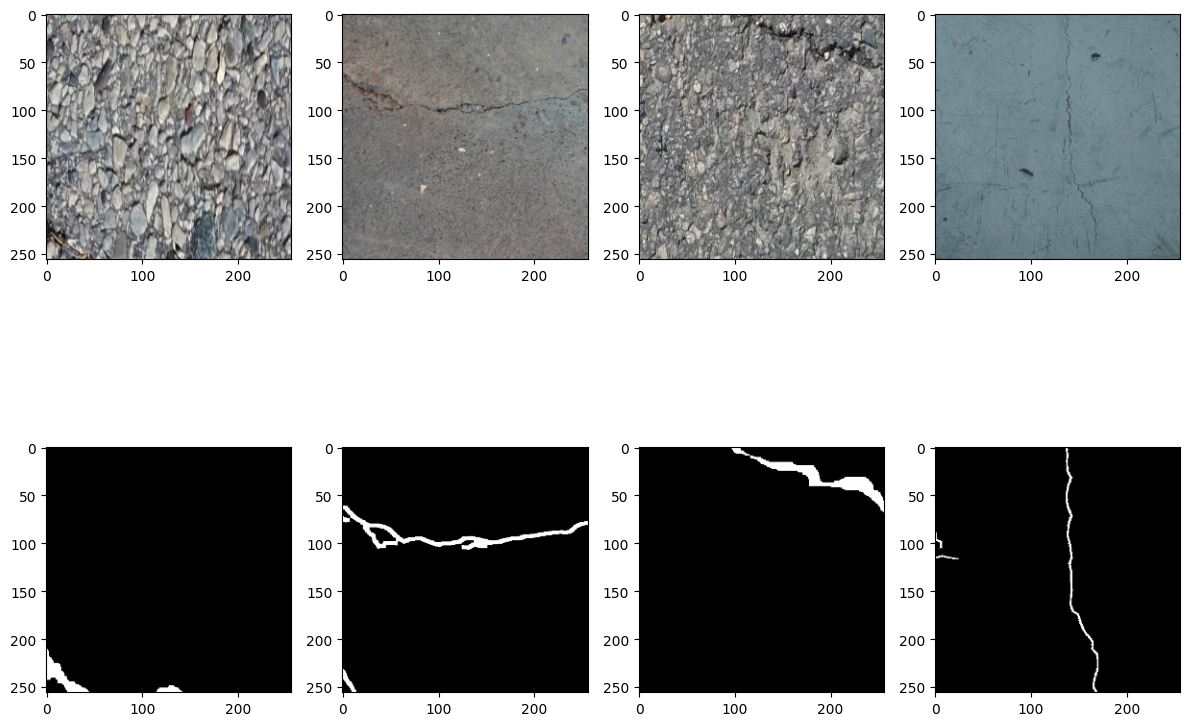

In [ ]:
import matplotlib.pyplot as plt
import random

image_dir = '/content/Conglomerate Concrete Crack Detection/Train/images'
mask_dir = '/content/Conglomerate Concrete Crack Detection/Train/masks'

image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

idx = random.sample(range(len(image_paths)), 4)

plt.figure(figsize = (12, 10))
for i in range(len(idx)):
    img, msk = load_image_mask(image_paths[idx[i]], mask_paths[idx[i]])

    plt.subplot(2,4, i + 1)
    plt.imshow(img)

    plt.subplot(2, 4, i + 5)
    plt.imshow(msk, cmap ='gray')

plt.tight_layout()
plt.show()

In [ ]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(rate = 0.5)(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(rate = 0.5)(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.layers.Input(shape = input_shape)

    s1, p1 = encoder_block(inputs, 32) # s- skip connection, p - pooling
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = tf.keras.layers.Conv2D(1, 1, padding = 'same', activation = 'sigmoid')(d4)

    model = tf.keras.models.Model(inputs, outputs, name ='U-Net')
    return model

input_shape = (256, 256, 3)
model = build_unet(input_shape)

In [ ]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)
model.fit(train_dataset, epochs = 2), val_dataset

Epoch 1/2
619/619 ━━━━━━━━━━━━━━━━━━━━ 293s 384ms/step - accuracy: 0.9129 - loss: 0.2378
Epoch 2/2
619/619 ━━━━━━━━━━━━━━━━━━━━ 246s 328ms/step - accuracy: 0.9515 - loss: 0.1139


(<keras.src.callbacks.history.History at 0x7c4e348c6250>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>)

In [ ]:
def dice_loss(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss =bce_dice_loss,
    metrics = [dice_coef]
)
model.fit(train_dataset, epochs=2, validation_data = val_dataset)

Epoch 1/2
 54/619 ━━━━━━━━━━━━━━━━━━━━ 2:58 316ms/step - dice_coef: 0.2156 - loss: 0.9188